In [1]:
import gymnasium as gym
from pyboy import PyBoy, WindowEvent
from gym import spaces
import numpy as np
import os
class GameBoyEnv(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}
    gameboy_buttons = [ WindowEvent.PRESS_BUTTON_A,WindowEvent.RELEASE_BUTTON_A,WindowEvent.PRESS_ARROW_RIGHT,WindowEvent.RELEASE_ARROW_RIGHT,WindowEvent.PRESS_BUTTON_B,WindowEvent.RELEASE_BUTTON_B]
    
        # [
        #     WindowEvent.PRESS_BUTTON_A, WindowEvent.PRESS_BUTTON_B,
        #     WindowEvent.PRESS_ARROW_UP, WindowEvent.PRESS_ARROW_DOWN,
        #     WindowEvent.PRESS_ARROW_LEFT, WindowEvent.PRESS_ARROW_RIGHT
        # ]
    
    time_steps = 0

    death_scalar=100
    survive_scalar=100
    frame_scalar=0.05
    level_scalar=0.0
    coin_scalar=0.00
    score_scalar=.1
    max_steps=4000

    class FrameStorage:
        def __init__(self):
            self.unique_frame_hashes = set()

        def __len__(self):
            # Return the number of unique frames
            return len(self.unique_frame_hashes)

        def add_frame(self, observation):
            #crop the top 35% of the screen
            observation = observation[35:,:,:]

            # Convert the frame to a byte string and then hash it
            frame_hash = hash(observation.tostring())
            reward = 1 if frame_hash not in self.unique_frame_hashes else 0
            self.unique_frame_hashes.add(frame_hash)
            return reward

    def __init__(self):
        super(GameBoyEnv, self).__init__()
        self.pyboy = PyBoy("roms/Super Mario Land (JUE) (V1.1) [!].gb")  # Use headless mode to prevent GUI issues
        self.action_space = spaces.Discrete(len(self.gameboy_buttons))  # Updated to match the number of buttons used in step
        self.observation_space = spaces.Box(low=0, high=255, shape=(160, 144, 3), dtype=np.uint8)
        self.unique_frames = self.FrameStorage()
        self.initialize_game()

    def initialize_game(self):
        self.pyboy.set_emulation_speed(0)  # 0 for max speed
        self.pyboy.send_input(WindowEvent.PRESS_BUTTON_START)
        for _ in range(100):  # Slight increase in tick count to ensure game starts
            self.pyboy.tick()
        
        if(not os.path.exists("initial_state.state")):
            self.pyboy.save_state(open("initial_state.state", "wb"))        

    def step(self, action):
        if action < len(self.gameboy_buttons):
            self.pyboy.send_input(self.gameboy_buttons[action])
        self.pyboy.tick()

        # Get the current frame from the emulator
        observation = self.pyboy.botsupport_manager().screen().screen_ndarray()

        # Additional rewards
        level_reward = self.get_level_reward()
        coin_reward = self.get_coin_reward()
        score_reward = self.get_score_reward()
        frame_reward = self.get_frame_reward(self.unique_frames.add_frame(observation))
        # Sum up all rewards
        reward = frame_reward
        # print(self.check_death_animation())
        # Check if the game is over
        done = self.check_game_over()
        # if(self.time_steps % 100 == 0):
        #     print(f"Reward: {reward} Level Reward: {level_reward} Coin Reward: {coin_reward} Score Reward: {score_reward} Frame Reward: {frame_reward}")
        if done:
            reward += level_reward + coin_reward + score_reward

            if(self.time_steps < self.max_steps):
                reward -= 1 * self.death_scalar 
            else: 
                reward += 1 * self.survive_scalar

        # Additional info (optional)
        info = {}
        self.time_steps += 1   

        if reward > 1000:
            reward = -100
        return observation, reward, done, info
    
    def check_death_animation(self):
        return self.pyboy.get_memory_value(0xFFA6) == 0x90

    def get_frame_reward(self, frame_reward):
        return frame_reward * self.frame_scalar
    
    def get_level_reward(self):
        current_world = self.pyboy.get_memory_value(0x982C)-1
        current_stage = self.pyboy.get_memory_value(0x982E)-1
        level = (current_world * 10) + current_stage  # Simplistic level calculation
        return level * self.level_scalar  # Adjust the reward scaling as needed

    def get_coin_reward(self):
        # Read the total amount of coins
        coins = self.pyboy.get_memory_value(0xFFFA)
        return coins * self.coin_scalar  # Adjust the reward scaling as needed
    
    def get_score(self):
        score_bytes = [self.pyboy.get_memory_value(addr) for addr in (0xC0A0, 0xC0A1, 0xC0A2)]
        score = bcd_to_int(score_bytes)
        return score

    def get_score_reward(self):
        return (self.get_score()-(100*self.pyboy.get_memory_value(0xFFFA))) * self.score_scalar  # Adjust the reward scaling as needed

    def reset(self):

        self.pyboy.load_state(open("initial_state.state", "rb"))
        # self.pyboy.reset_game()
        self.initialize_game()
        self.unique_frames = self.FrameStorage()  # Reset the frame storage
        self.time_steps = 0
        return self.pyboy.botsupport_manager().screen().screen_ndarray()

    def check_game_over(self):
        
        return self.pyboy.get_memory_value(0xDA15) <2 or self.time_steps > self.max_steps

    def close(self):
        self.pyboy.stop()

    def render(self, mode='human'):
        if mode == 'rgb_array':
            return self.pyboy.botsupport_manager().screen().screen_ndarray()
        elif mode == 'human':
            img = self.pyboy.botsupport_manager().screen().screen_ndarray()
            plt.imshow(img)
            plt.show()
        
        
def bcd_to_int(bcd_bytes):
    """
    Convert a sequence of BCD (Binary-Coded Decimal) bytes to an integer.
    bcd_bytes: A list or tuple of bytes representing the BCD value, 
               ordered from most significant byte to least significant byte.
    """
    total_value = 0
    # Process each BCD byte starting from the most significant byte
    for byte in bcd_bytes:
        # Shift the total value by a decimal place (multiply by 10) for each nibble (4 bits) in the byte
        for nibble_shift in (4, 0):
            nibble_value = (byte >> nibble_shift) & 0xF
            total_value = total_value * 10 + nibble_value
    return total_value

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import random
from collections import deque
import gym


class ImprovedDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(ImprovedDQN, self).__init__()
        print("input shape:",input_shape)
        if len(input_shape) == 3 and input_shape[-1] in [1, 3]:  # Assuming color or grayscale
            input_shape = (input_shape[2], input_shape[0], input_shape[1])  # Rearrange to (C, H, W)
        print("Corrected input shape:", input_shape)
        input_shape = (input_shape[0], input_shape[1] // 2, input_shape[2] // 2)  # Adjusting the shape
        print("Adjusted input shape after pooling:", input_shape)
        self.input_dim = np.prod(input_shape) 
        
        self.autoencoder = Autoencoder()
        self.feature_extractor = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])  # Remove the last two layers
        self.max_pool = nn.MaxPool2d(2, 2)

        # Optionally freeze ResNet layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        # Define the fully connected layers for action prediction
        self.fc_layers = nn.Sequential(
            nn.Linear(self._get_conv_output(input_shape), 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        
        self.apply(self.init_weights)  # Apply weight initialization

    def _get_conv_output(self, shape):
        # Corrected to use feature_extractor instead of conv_layers
        with torch.no_grad():
            return self.feature_extractor(torch.zeros(1, *shape)).view(1, -1).size(1)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier initialization
            m.bias.data.fill_(0.01)  # Initialize biases to a small value

    def forward(self, x):
        x = x.float() / 255.0  # Normalize input
        x = self.max_pool(x)
        x = self.feature_extractor(x)
        # Use .reshape() instead of .view() to handle non-contiguous tensors
        x = x.reshape(x.size(0), -1)  # Flatten the output of feature_extractor
        x = self.fc_layers(x)  # Pass the flattened features through the fc_layers
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # output: 16 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # output: 32 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # output: 64 x 2 x 2
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Assuming input images are normalized between [0, 1]
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.autoencoder = Autoencoder()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])  # Remove the last two layers
        
        # Optionally freeze ResNet layers
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        encoded, _ = self.autoencoder(x)  # Ignore the decoder output for feature extraction
        features = self.resnet(encoded)
        return features

c:\Users\saile\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), action, reward, np.array(next_state), done
    
    def clear(self):
        self.buffer.clear()

    def __len__(self):
        return len(self.buffer)


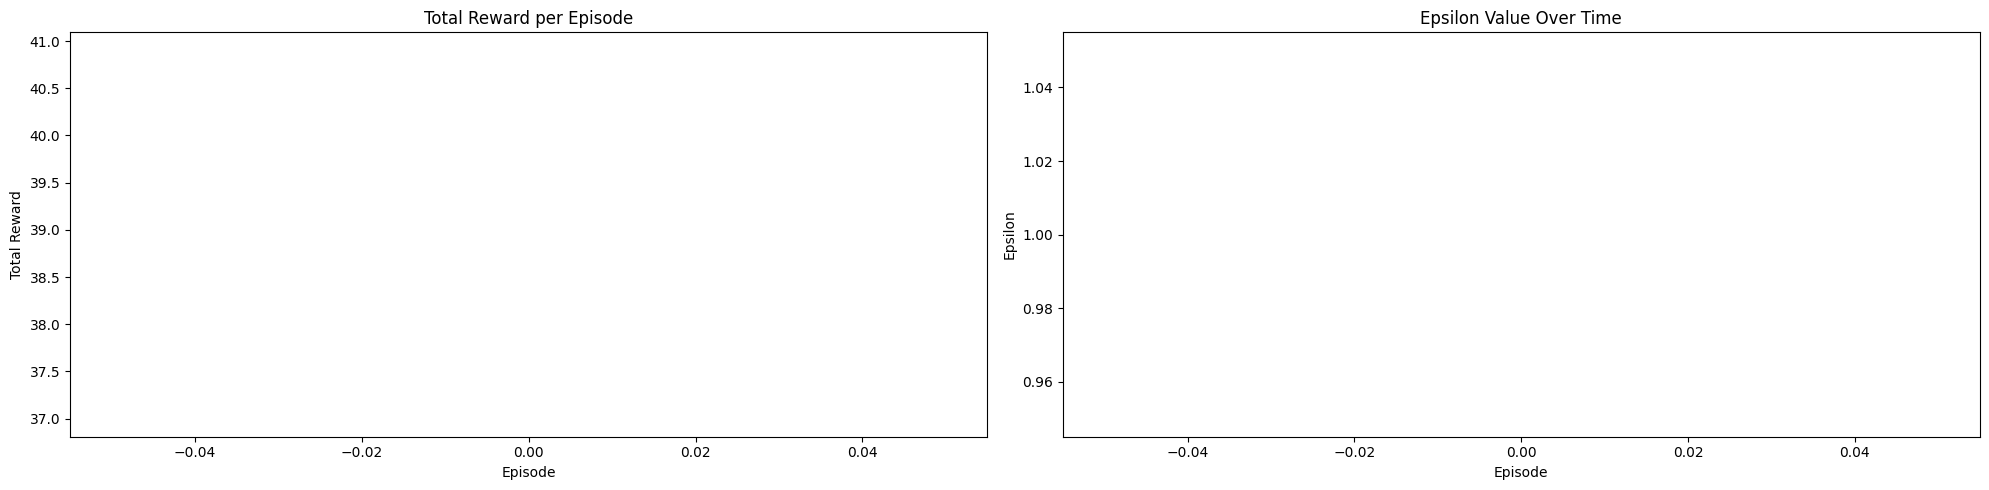

Episode: 0, Total reward: 38.95000000000013, Epsilon: 0.999, Time Steps: 447
(144, 160, 3)


ValueError: axes don't match array

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class Agent:
    def __init__(self, env):
        self.env = env
        self.replay_buffer = ReplayBuffer(100000)
        self.state_shape = env.observation_space.shape
        self.n_actions = env.action_space.n
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.total_rewards = []
        self.epsilons = []

        self.model = ImprovedDQN(self.state_shape, self.n_actions).to(self.device)
        self.target_model = ImprovedDQN(self.state_shape, self.n_actions).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters())
        self.loss_fn = nn.MSELoss()

        self.gamma = 0.99
        self.batch_size = 32
        self.epsilon = 1
        self.epsilon_decay = .999
        self.epsilon_min = 0.01
        self.update_target_every = 30
        self.n_ticks_to_skip = 2

    def act(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        state = np.transpose(state, (2, 0, 1))
        print(state.shape)
        state_t = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # Ensure the input tensor is correctly shaped
        q_values = self.model(state_t)
        return q_values.max(1)[1].item()

    def plot(self):
        clear_output(wait=True)
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 2, 1)
        plt.title("Total Reward per Episode")
        plt.plot(self.total_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        
        plt.subplot(1, 2, 2)
        plt.title("Epsilon Value Over Time")
        plt.plot(self.epsilons)
        plt.xlabel("Episode")
        plt.ylabel("Epsilon")

        plt.tight_layout()
        plt.show()

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)
        state = torch.FloatTensor(state.transpose(0, 3, 1, 2)).to(self.device)
        # print(state.shape)
        next_state = torch.FloatTensor(next_state.transpose(0, 3, 1, 2)).to(self.device)
        action = torch.LongTensor(action).unsqueeze(-1).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        done = torch.FloatTensor(done).to(self.device)

        q_values = self.model(state).gather(1, action).squeeze(-1)
        next_q_values = self.target_model(next_state).max(1)[0]
        expected_q_values = reward + self.gamma * next_q_values * (1 - done)

        loss = self.loss_fn(q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes, start=0):
        if os.path.exists(f"checkpoints/model_{start}.pth"):
            self.model.load_state_dict(torch.load(f"checkpoints/model_{start}.pth"))
            self.target_model.load_state_dict(torch.load(f"checkpoints/model_{start}.pth"))

        for episode in range(start, num_episodes):
            state = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                self.replay_buffer.push(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward

                # Skip n intermediate steps
                for _ in range(self.n_ticks_to_skip):
                    self.env.pyboy.tick()

                self.update()

            self.total_rewards.append(total_reward)
            self.epsilons.append(self.epsilon)

            # Decay epsilon after each episode
            self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

            self.plot() 

            print(f"Episode: {episode}, Total reward: {total_reward}, Epsilon: {self.epsilon}, Time Steps: {self.env.time_steps}")

            if episode % 50 == 0:
                torch.save(self.model.state_dict(), f"checkpoints/model_{episode}.pth")

            

print( torch.cuda.is_available())
env = GameBoyEnv()
agent = Agent(env)

agent.train(7500,0)  # Train for 1000 episodes
